<a href="https://www.kaggle.com/code/pawan2905/demand-forecasting?scriptVersionId=103316514" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential


/kaggle/input/hackathon-april-20222/WhatsApp Image 2022-04-22 at 11.41.38 AM (2).jpeg
/kaggle/input/hackathon-april-20222/sample.csv
/kaggle/input/hackathon-april-20222/train.csv
/kaggle/input/hackathon-april-20222/test.csv
/kaggle/input/hackathon-april-20222/WhatsApp Image 2022-04-22 at 11.41.38 AM.jpeg
/kaggle/input/hackathon-april-20222/WhatsApp Image 2022-04-22 at 11.41.38 AM (1).jpeg


In [2]:
train = pd.read_csv("../input/hackathon-april-20222/train.csv")
test = pd.read_csv("../input/hackathon-april-20222/test.csv")
sample_sub = pd.read_csv("../input/hackathon-april-20222/sample.csv")

In [3]:
def dataPreprocessing(dataFrame):
    dataFrame['date'] = pd.to_datetime(dataFrame['date']) + dataFrame['hour'].astype('timedelta64[h]')
    dataFrame.drop(columns=['hour'], axis=1, inplace=True)
    return dataFrame

In [4]:
train['date'] = pd.to_datetime(train['date'])

In [5]:
print(f"starting date : {str(train['date'].dt.date.min())}")
print(f"end date : {str(train['date'].dt.date.max())}")

starting date : 2018-08-18
end date : 2021-02-28


In [6]:
training_data = dataPreprocessing(train)
training_data= training_data.set_index("date")
training_data.head()

,demand
date,
2018-08-18 09:00:00,91
2018-08-18 10:00:00,21
2018-08-18 13:00:00,23
2018-08-18 14:00:00,104
2018-08-18 15:00:00,81


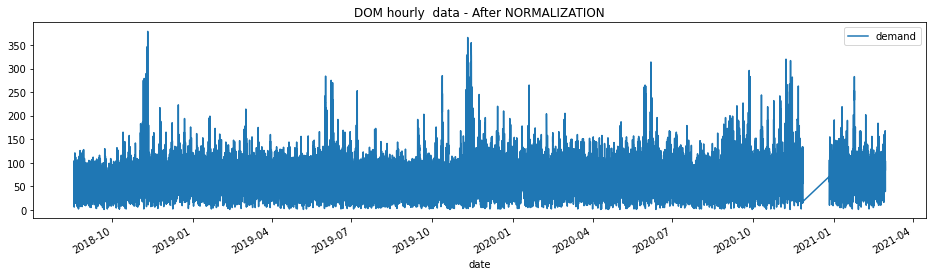

In [7]:
training_data.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly  data - After NORMALIZATION')

plt.show()

In [8]:
training_data

,demand
date,
2018-08-18 09:00:00,91
2018-08-18 10:00:00,21
2018-08-18 13:00:00,23
2018-08-18 14:00:00,104
2018-08-18 15:00:00,81
...,...
2021-02-28 19:00:00,95
2021-02-28 20:00:00,88
2021-02-28 21:00:00,39


In [9]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['demand']=scaler.fit_transform(df['demand'].values.reshape(-1,1))
    return df

df_norm = normalize_data(training_data)
df_norm.shape

(18247, 1)

In [10]:
df_norm

,demand
date,
2018-08-18 09:00:00,0.238095
2018-08-18 10:00:00,0.052910
2018-08-18 13:00:00,0.058201
2018-08-18 14:00:00,0.272487
2018-08-18 15:00:00,0.211640
...,...
2021-02-28 19:00:00,0.248677
2021-02-28 20:00:00,0.230159
2021-02-28 21:00:00,0.100529


In [11]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[14597:]             
    y_test = y_train[14597:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:14597]           
    y_train = y_train[:14597]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (14597, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [12]:
#create train, test data
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(training_data, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (14597, 20, 1)
y_train.shape =  (14597,)
X_test.shape =  (3630, 20, 1)
y_test.shape =  (3630,)


In [13]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

2022-08-15 04:45:02.550523: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 20, 40)            1680      
_________________________________________________________________
dropout (Dropout)            (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20, 40)            3240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 4

In [14]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

2022-08-15 04:45:03.157747: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
15/15 [==============================] - 4s 80ms/step - loss: 0.1450
Epoch 2/10
15/15 [==============================] - 1s 81ms/step - loss: 0.0743
Epoch 3/10
15/15 [==============================] - 2s 103ms/step - loss: 0.0454
Epoch 4/10
15/15 [==============================] - 1s 91ms/step - loss: 0.0323
Epoch 5/10
15/15 [==============================] - 1s 85ms/step - loss: 0.0256
Epoch 6/10
15/15 [==============================] - 1s 100ms/step - loss: 0.0207
Epoch 7/10
15/15 [==============================] - 1s 93ms/step - loss: 0.0187
Epoch 8/10
15/15 [==============================] - 1s 85ms/step - loss: 0.0169
Epoch 9/10
15/15 [==============================] - 1s 96ms/step - loss: 0.0151
Epoch 10/10
15/15 [==============================] - 2s 99ms/step - loss: 0.0139


In [15]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

R2 Score of RNN model =  0.3454178325968713


In [16]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual  data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted  data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized scale')
    plt.legend()
    plt.show()
    

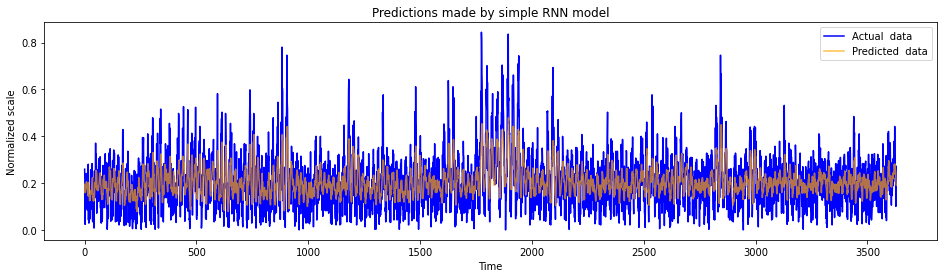

In [17]:
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

In [18]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 40)            6720      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 40)            12960     
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_5 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [19]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
15/15 [==============================] - 9s 185ms/step - loss: 0.0180
Epoch 2/10
15/15 [==============================] - 3s 192ms/step - loss: 0.0122
Epoch 3/10
15/15 [==============================] - 3s 185ms/step - loss: 0.0116
Epoch 4/10
15/15 [==============================] - 3s 186ms/step - loss: 0.0115
Epoch 5/10
15/15 [==============================] - 3s 188ms/step - loss: 0.0114
Epoch 6/10
15/15 [==============================] - 3s 194ms/step - loss: 0.0113
Epoch 7/10
15/15 [==============================] - 3s 189ms/step - loss: 0.0113
Epoch 8/10
15/15 [==============================] - 3s 185ms/step - loss: 0.0112
Epoch 9/10
15/15 [==============================] - 3s 185ms/step - loss: 0.0111
Epoch 10/10
15/15 [==============================] - 3s 189ms/step - loss: 0.0110


In [20]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  0.03803017133547171


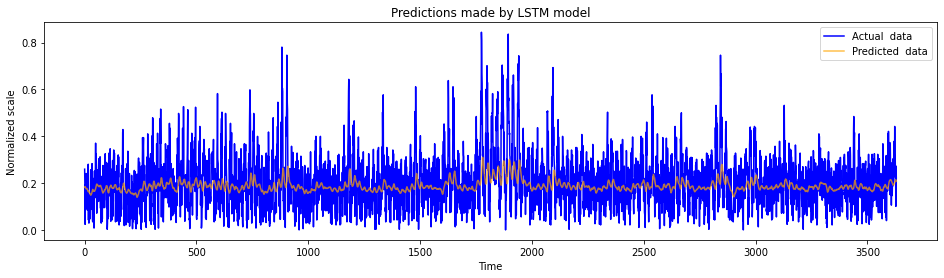

In [21]:
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

In [22]:
test['date'] = pd.to_datetime(train['date'])

In [23]:
train_df = train

In [24]:
train_df

,date,demand
0,2018-08-18 09:00:00,91
1,2018-08-18 10:00:00,21
2,2018-08-18 13:00:00,23
3,2018-08-18 14:00:00,104
4,2018-08-18 15:00:00,81
...,...,...
18242,2021-02-28 19:00:00,95
18243,2021-02-28 20:00:00,88
18244,2021-02-28 21:00:00,39
18245,2021-02-28 22:00:00,104


In [25]:
import plotly.express as px
fig = px.line(train_df, x='date', y='demand')

fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [26]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [27]:
train_df.rename(columns={'date': 'ds', 'demand': 'y'}, inplace=True)
train_data = train_df.sample(frac=0.8, random_state=10)

validation_data = train_df.drop(train_data.index)

print(f'training data size : {train_data.shape}')
print(f'validation data size : {validation_data.shape}')

train_data = train_data.reset_index()
validation_data = validation_data.reset_index()

training data size : (14598, 2)
validation data size : (3649, 2)


In [28]:
from sklearn.metrics import mean_absolute_error
from fbprophet import Prophet

In [29]:
model = Prophet()
model.fit(train_data)

Initial log joint probability = -117.991
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       26890.6   0.000503129       131.001           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       26892.8   0.000134656       101.257      0.9252      0.9252      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       26893.1   0.000491576       150.762           1           1      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     336       26893.2    2.2201e-05       67.6894   2.592e-07       0.001      462  LS failed, Hessian reset 
     385       26893.2   2.56929e-06       75.8597    3.26e-08       0.001      570  LS failed, Hessian reset 
     389       26893.2   1.19708e-06       67.5392      0.6609      0.6609      574   
Optimization terminat

In [30]:
prediction = model.predict(pd.DataFrame({'ds':validation_data['ds']}))
y_actual = validation_data['y']
y_predicted = prediction['yhat']
y_predicted = y_predicted.astype(int)
mean_absolute_error(y_actual, y_predicted)

29.686763496848453

In [31]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=validation_data['ds'], y=y_actual, name="actual targets"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=validation_data['ds'], y=y_predicted, name="predicted targets"),
    secondary_y=True,
)

fig.update_layout(
    title_text="Actual vs Predicted Targets"
)

fig.update_xaxes(title_text="Timeline")
fig.update_yaxes(title_text="<b>actual</b> targets", secondary_y=False)
fig.update_yaxes(title_text="<b>predicted</b> targets", secondary_y=True)

fig.show()

In [32]:
test_data = pd.read_csv('../input/hackathon-april-20222/test.csv')
print(f'test dataset size : {test_data.shape}')
testing_data = dataPreprocessing(test_data.copy())
testing_data.head()

test dataset size : (7650, 2)


,date
0,2021-03-01 00:00:00
1,2021-03-01 01:00:00
2,2021-03-01 02:00:00
3,2021-03-01 03:00:00
4,2021-03-01 05:00:00


In [33]:
test_prediction = model.predict(pd.DataFrame({'ds':testing_data['date']}))

In [34]:
test_prediction = test_prediction['yhat']
test_prediction = test_prediction.astype(int)
test_data['demand'] = test_prediction
test_data.head()
test_data.to_csv('submission.csv', index=False)

In [35]:
test_data

,date,hour,demand
0,2021-03-01,0,65
1,2021-03-01,1,61
2,2021-03-01,2,58
3,2021-03-01,3,55
4,2021-03-01,5,55
...,...,...,...
7645,2022-03-28,19,75
7646,2022-03-28,20,67
7647,2022-03-28,21,59
7648,2022-03-28,22,55
